In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Tesla_data.csv')

In [3]:
data.head(3)

,Date,Close,lag_O,lag_H,lag_L,lag_C,lag_A,Year,Month,Day,Weekday
0,2010-07-02,0.000554,0.000465,0.001350,0.000422,0.001319,0.001319,0.0,0.545455,0.033333,1.00
1,2010-07-06,0.000051,0.001568,0.002224,0.001371,0.001309,0.001309,0.0,0.545455,0.166667,0.25
2,2010-07-07,0.000000,0.001439,0.001498,0.000871,0.001004,0.001004,0.0,0.545455,0.200000,0.50


In [4]:
data.shape

(3140, 11)

In [5]:
train = data[:-92]
test = data[-92:]
print(train.shape)
print(test.shape)

(3048, 11)
(92, 11)


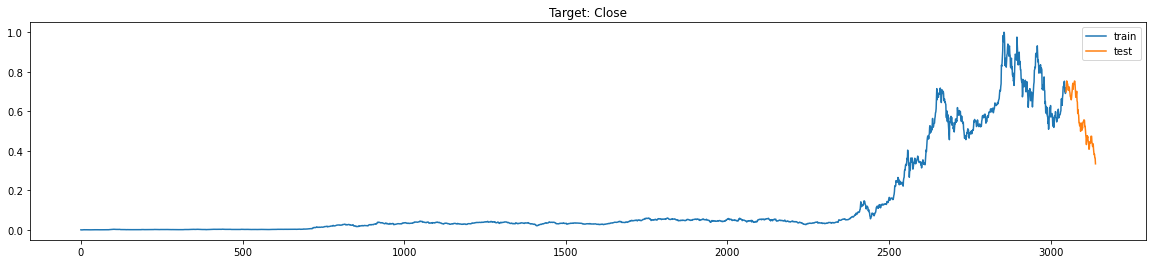

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target: Close')
plt.plot(train['Close'], label = 'train')
plt.plot(test['Close'], label = 'test')

plt.legend()
plt.show()

In [7]:
x_train = train.drop(columns = {'Date','Close'}, axis = 1)
y_train = train.loc[:, ['Close']]

x_test = test.drop(columns = {'Date','Close'}, axis = 1)
y_test = test.loc[:, ['Close']]

# LightGBM

In [8]:
import lightgbm as lgb

In [9]:
model = lgb.LGBMRegressor().fit(x_train, y_train)
pred = model.predict(x_test)

In [10]:
def slide_pred(lag_n, pred):
    prediction = list(pred)
    prediction = prediction[lag_n:]
        
    return prediction

In [11]:
pred = slide_pred(3, pred)
y_test = y_test[:-3]

In [12]:
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.7777450890678272   ;   MSE:  0.002297647647371748


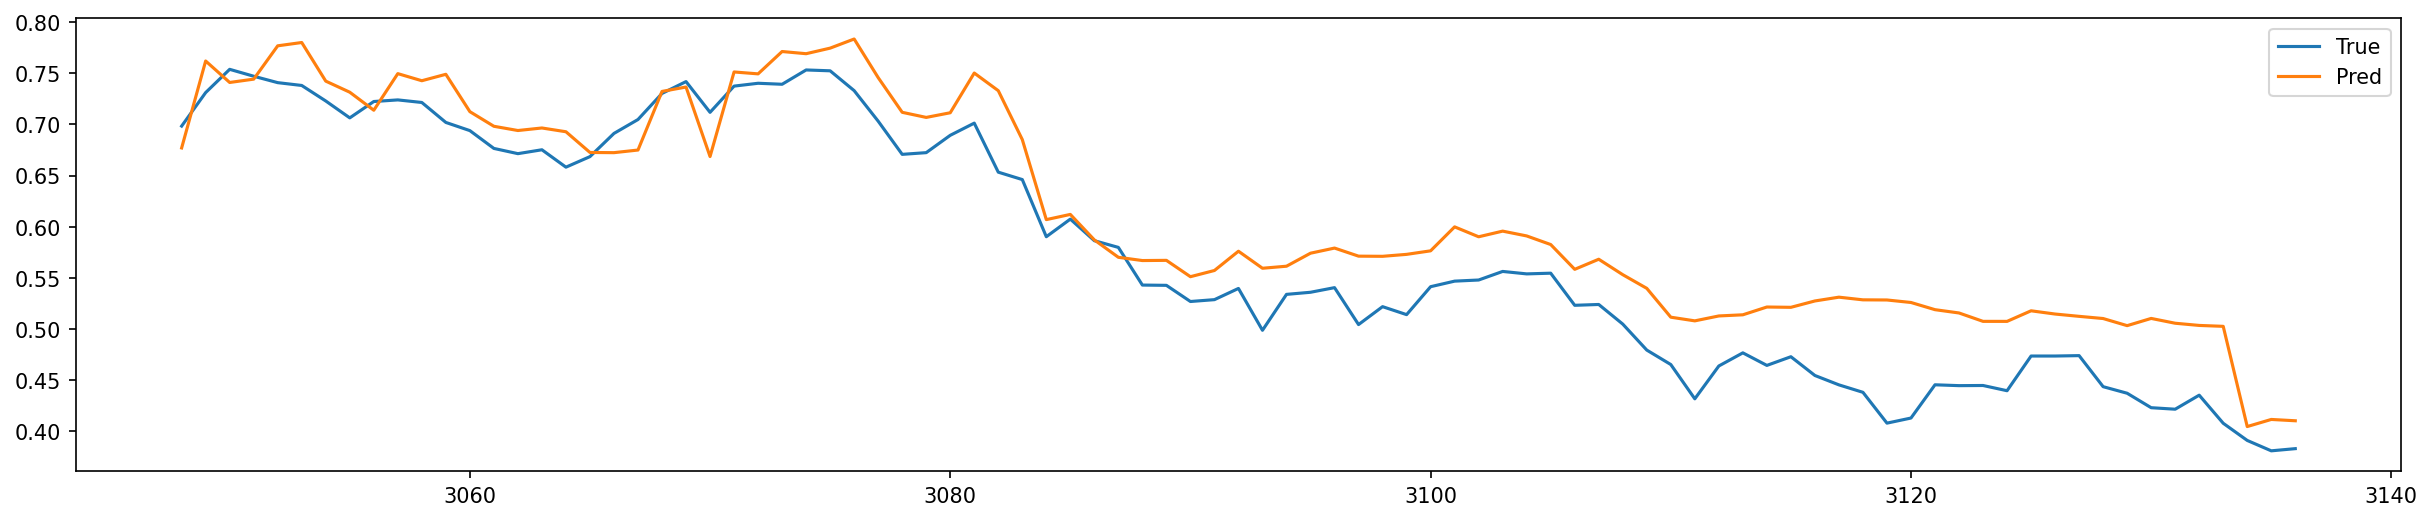

In [13]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Close'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of LightGBM

In [14]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [15]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 11
interp_x= x_train
model = model

ShapTime_lgb = ShapleyValues(model, interp_x, Tn)

In [16]:
ShapTime_lgb

[-0.03705639390925829,
 -0.036835264951342477,
 -0.034583781346737084,
 -0.028278437047688152,
 -0.02733657625277138,
 -0.028068361878739522,
 -0.022836152441223025,
 -0.02353974200425902,
 -0.01850180194627465,
 0.08988742556627674,
 0.16719081359868534]

In [17]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10']

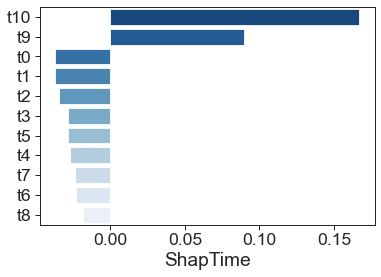

In [18]:
TimeImportance(Tn, ShapTime_lgb, time_columns)

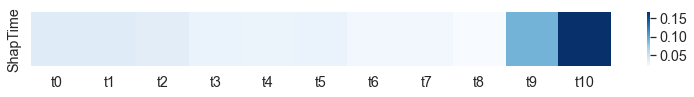

In [19]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [20]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [21]:
n = 5
Tn = 11
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [22]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [23]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,-0.037056,-0.036835,-0.034584,-0.028278,-0.027337,-0.028068,-0.022836,-0.023540,-0.018502,0.089887,0.167191
1,-0.037056,-0.036835,-0.034583,-0.028280,-0.027335,-0.028064,-0.022834,-0.023553,-0.018508,0.089876,0.167214
2,-0.037051,-0.036837,-0.034587,-0.028278,-0.027340,-0.028071,-0.022832,-0.023529,-0.018503,0.089888,0.167183
3,-0.037050,-0.036833,-0.034583,-0.028273,-0.027338,-0.028071,-0.022853,-0.023557,-0.018475,0.089910,0.167165
4,-0.037050,-0.036833,-0.034583,-0.028273,-0.027338,-0.028071,-0.022853,-0.023557,-0.018475,0.089910,0.167165
5,-0.037041,-0.036854,-0.034567,-0.028297,-0.027387,-0.027908,-0.022958,-0.023627,-0.018451,0.089719,0.167413


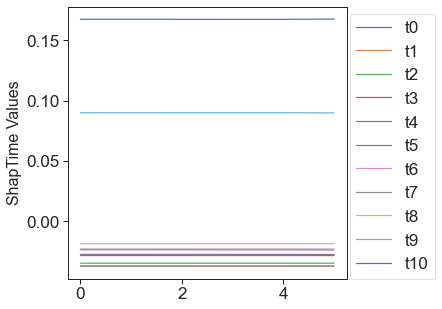

In [24]:
PlotVal(result)

### Sensitivity

In [26]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
situation_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 8]

In [27]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'Date')
df_eva = supertime(11, train_eva)
model_eva =  lgb.LGBMRegressor()

In [28]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [29]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'Close', model_eva, total)

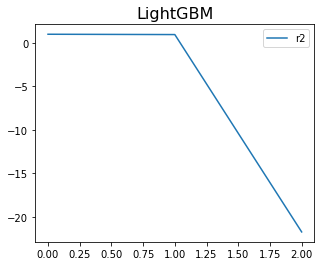

In [30]:
R2Plot(r2_results, 'LightGBM')

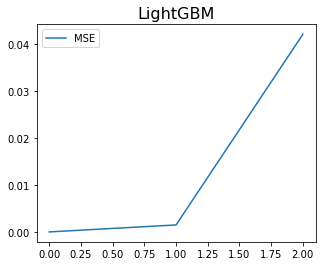

In [31]:
MSEPlot(mse_results, 'LightGBM')

# Improvement

In [32]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [33]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t7, t10, t9, t10]

In [34]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'Date', 'Close'}, axis = 1)
y_check = check.loc[:, ['Close']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)
pred_check = model_check.predict(x_test)

In [35]:
pred_check = slide_pred(3, pred_check)

In [36]:
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.8038862373689707 Degree of Improvement: 3.36%
0.0021957579963136015 Degree of Improvement: 4.43%


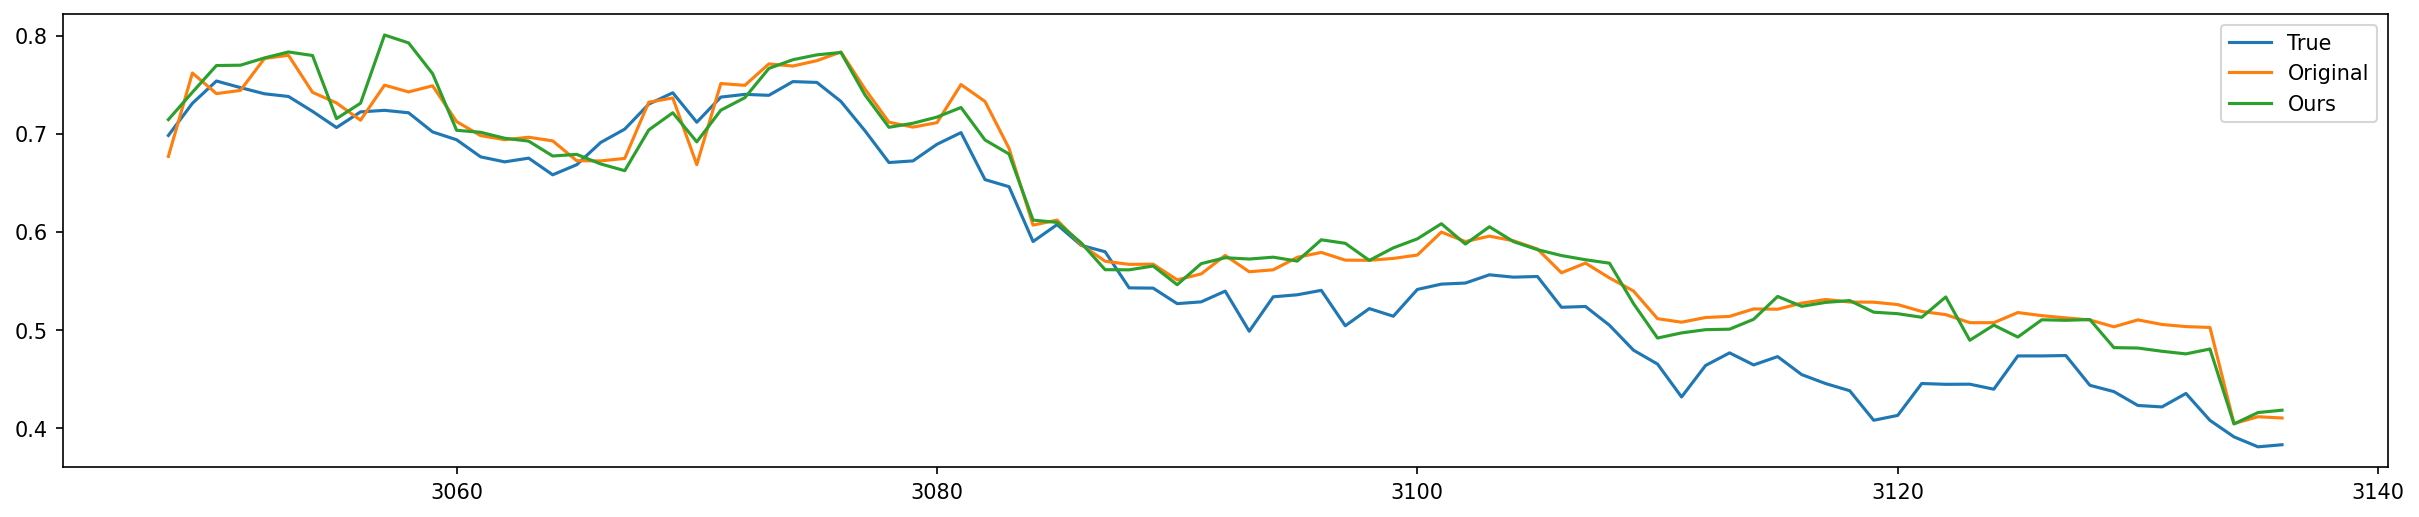

In [37]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)


sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Close'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend()

plt.show()